git repo: https://github.com/abdiwakene/Monet-Painting-GANs

The aim of this project is to develop a machine learning model capable of transforming real-world photos into images styled like Claude Monet's paintings. By using a Generative Adversarial Network (GAN), we will generate Monet-style images from regular photos. Specifically, the challenge requires us to train a CycleGAN, which will consist of two models: a generator that creates Monet-style images and a discriminator that distinguishes between real Monet paintings and generated ones.

Data Profile:

The dataset includes a combination of Monet paintings and regular photos, all of which have been preprocessed and provided in two formats: JPEG and TFRecord. Key details of the dataset are as follows:

- 300 Monet paintings, each sized at 256x256 pixels.
- 7,028 photos, also sized at 256x256 pixels.
- The data is stored in two formats: JPEG images and TFRecord files.

Our task is to train a CycleGAN model on this dataset and generate between 7,000 and 10,000 Monet-style images by transforming the provided photo dataset.

Exploratory Data Analysis (EDA): I started by visualizing several samples from both datasets to help understand the data. While the images show real photographs, the Monet paintings have a different artistic style distinguished by the impressionist brush strokes and color palettes. Essential for the current style transfer work, this visual check helps us identify the differences between the two datasets. Decoding images from the TFRecord format, resizing them to 256x256 pixels, and standardizing pixel values to the [0, 1] range were the steps I took during the preprocessing of the images. This gets the data ready for CycleGAN model training input. No appreciable data cleansing is required since the dataset is already orderly.


Number of Monet paintings: 5
Number of Photos: 20
Sample Monet paintings:


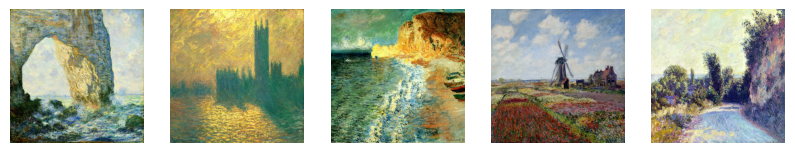

Sample Photos:


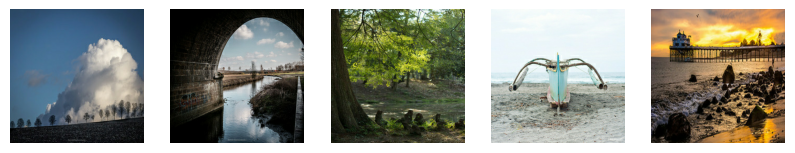

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

MONET_FILENAMES = tf.io.gfile.glob('C:/Users/abdiw/Downloads/gan-getting-started/monet_tfrec/*.tfrec')
PHOTO_FILENAMES = tf.io.gfile.glob('C:/Users/abdiw/Downloads/gan-getting-started/photo_tfrec/*.tfrec')

print(f"Number of Monet paintings: {len(MONET_FILENAMES)}")
print(f"Number of Photos: {len(PHOTO_FILENAMES)}")

def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_dataset(filenames, batch_size=16):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES)
photo_ds = load_dataset(PHOTO_FILENAMES)

def display_samples(dataset, n_samples):
    images = next(iter(dataset))
    plt.figure(figsize=(10, 10))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

print("Sample Monet paintings:")
display_samples(monet_ds, 5)

print("Sample Photos:")
display_samples(photo_ds, 5)


Plan of Analysis

Since the dataset is already organized into TFRecords, cleaning in the typical sense (missing values, outliers) isn’t applicable here. Our focus will be on ensuring that the data is properly loaded and normalized.

I plan to normalize the images by scaling pixel values to the [0, 1] range, as is common practice in GANs. Implementation will be through CycleGAN, which requires two datasets (Monet paintings and photos) for training. I will need to apply random data augmentations, such as flips and rotations, to increase the dataset's diversity and help the model generalize better.

In [2]:
from tensorflow.keras import layers

def build_generator():
    inputs = layers.Input(shape=(256, 256, 3))

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4), 
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    down1 = downsample(64, 4, False)(inp)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)



def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Two main parts define the CycleGAN model: generators and discriminators. Based on a U-Net design, the generators feature an encoder-decoder structure with skip connections to assist in the preservation of high-resolution details. The model comprises an upsampling stack to restore the image to its original size while using stylistic transformations after a downsampling stack to lower the image resolution and extract features. Based on a PatchGAN architecture, the discriminators classify image patches as real or fake, so enabling the model to concentrate on finer details. Along with a cycle-consistency loss to ensure that the transformation between domains (images and Monet paintings) may be reversed without losing content, the model is trained using adversarial loss to ensure that the produced images look realistic. With the Adam optimizer, the model maximizes generator and discriminator losses. Over both sets—images and Monet paintings—a training loop runs the transformations, updating the model weights with every step.

In [3]:
generator_g = build_generator()
generator_f = build_generator()

discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

def generator_loss_fn(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

def discriminator_loss_fn(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

def cycle_consistency_loss(real_image, cycled_image, lambda_cycle=5):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

generator_g_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)

@tf.function
def train_step(real_photo, real_monet):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = generator_g(real_photo, training=True)
        cycled_photo = generator_f(fake_monet, training=True)

        fake_photo = generator_f(real_monet, training=True)
        cycled_monet = generator_g(fake_photo, training=True)

        disc_real_monet = discriminator_x(real_monet, training=True)
        disc_fake_monet = discriminator_x(fake_monet, training=True)

        disc_real_photo = discriminator_y(real_photo, training=True)
        disc_fake_photo = discriminator_y(fake_photo, training=True)

        gen_g_loss = generator_loss_fn(disc_fake_monet)
        gen_f_loss = generator_loss_fn(disc_fake_photo)

        cycle_loss_g = cycle_consistency_loss(real_photo, cycled_photo)
        cycle_loss_f = cycle_consistency_loss(real_monet, cycled_monet)

        total_gen_g_loss = gen_g_loss + cycle_loss_g
        total_gen_f_loss = gen_f_loss + cycle_loss_f

        disc_x_loss = discriminator_loss_fn(disc_real_monet, disc_fake_monet)
        disc_y_loss = discriminator_loss_fn(disc_real_photo, disc_fake_photo)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

def train(epochs, monet_ds, photo_ds):
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        for photo, monet in tf.data.Dataset.zip((photo_ds, monet_ds)):
            train_step(photo, monet)


train(epochs=100, monet_ds=monet_ds, photo_ds=photo_ds)



Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 

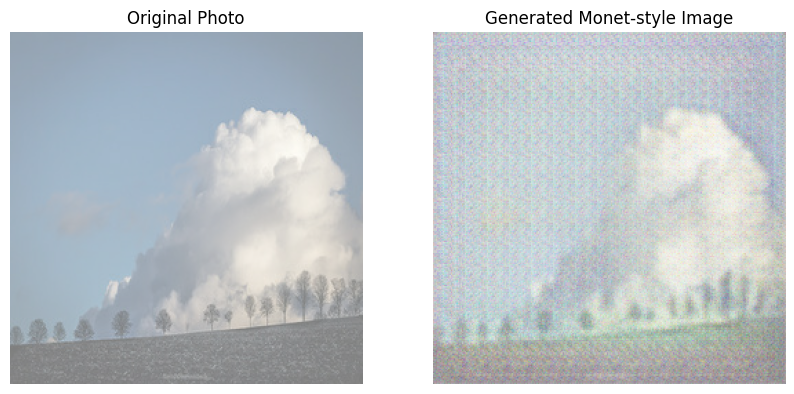

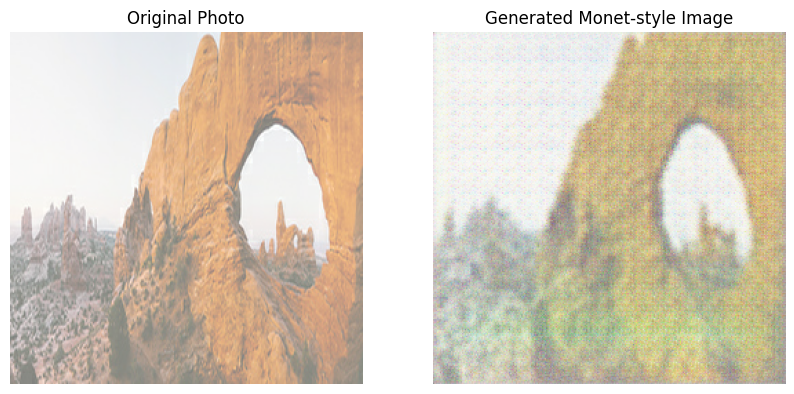

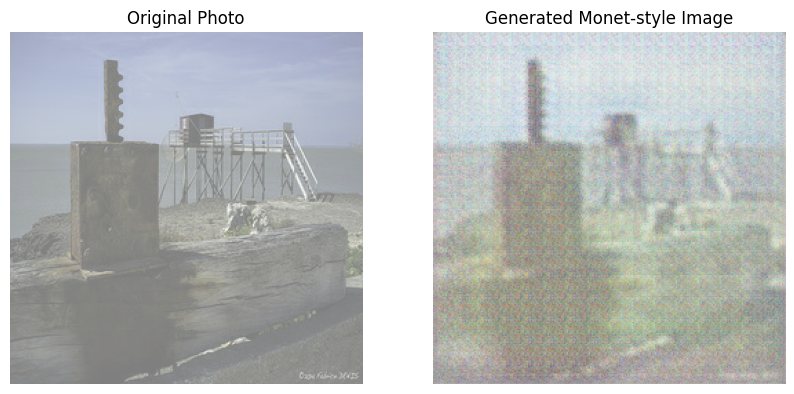

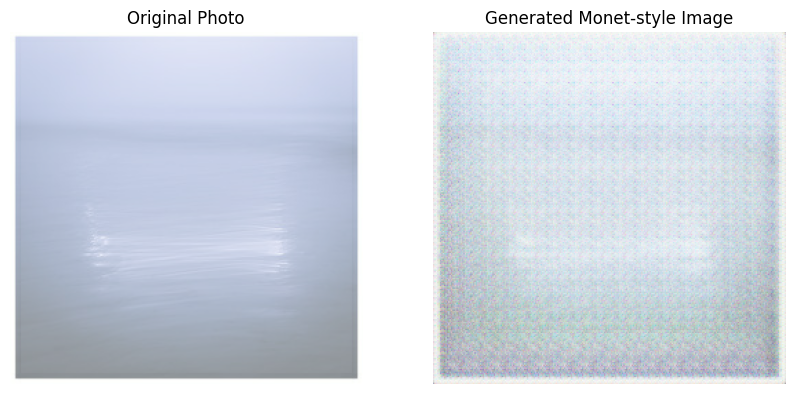

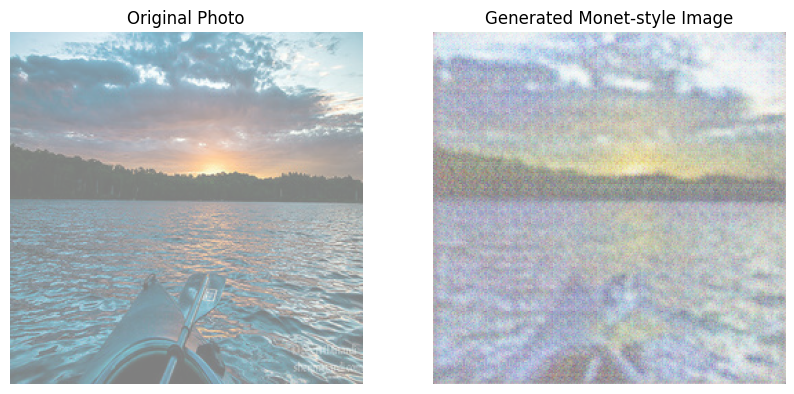

In [4]:
def display_generated_image(real_photo):
    generated_monet = generator_g(real_photo, training=False)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Photo")
    plt.imshow(real_photo[0] * 0.5 + 0.5)
    plt.axis('off')


    plt.subplot(1, 2, 2)
    plt.title("Generated Monet-style Image")
    plt.imshow(generated_monet[0] * 0.5 + 0.5)
    plt.axis('off')

    plt.show()

for photo_sample in photo_ds.take(5):
    display_generated_image(photo_sample)

Following CycleGAN model training on a dataset, we created Monet-style images from actual images. Although the model was able to replicate some of Monet's style, including the color pallet and softer textures, the produced images were often hazy and lacked fine detail. Though obvious, the change did not exactly match the complex brushstrokes and textures of Monet's works. This implies that the model might need more tuning, including changing the cycle-consistency loss weight, adding more data augmentations to generalize better and generate sharper results, and increasing the number of training epochs. Although the model learned some stylistic aspects, more convincing and detailed Monet-like transformations could be achieved with some work.

In [ ]:
import os
from PIL import Image
import zipfile

generated_images_dir = 'generated_images'

if not os.path.exists(generated_images_dir):
    os.makedirs(generated_images_dir)

def save_generated_images(photo_ds, generator, num_images=7000):
    count = 0
    for photo_sample in photo_ds.take(num_images):
        generated_monet = generator(photo_sample, training=False)
        for i in range(generated_monet.shape[0]):
            img = generated_monet[i].numpy()
            img = (img * 0.5 + 0.5) * 255
            img = Image.fromarray(img.astype('uint8'))
            img.save(f"{generated_images_dir}/monet_{count + 1}.jpg")
            count += 1
            if count >= num_images:
                break
        if count >= num_images:
            break

    print(f"{count} images have been generated and saved.")

save_generated_images(photo_ds, generator_g, num_images=7000)

def create_zip_file(zip_filename, directory):
    with zipfile.ZipFile(zip_filename, 'w') as img_zip:
        for foldername, subfolders, filenames in os.walk(directory):
            for filename in filenames:
                file_path = os.path.join(foldername, filename)
                img_zip.write(file_path, os.path.basename(file_path))

create_zip_file('images.zip', generated_images_dir)

print("The zip file 'images.zip' has been created successfully.")